# Measuring creativity

Once you've trained a pass selection, pass outcome and pass value model, they can be combined to measure the creativity of a pass.

In [48]:
from pathlib import Path
from functools import partial

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import mlflow
from scipy.ndimage import zoom
import torch
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.filterwarnings("ignore", category=UserWarning, module="mlflow.utils.autologging_utils")

In [49]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
import os, sys
import tqdm
sys.path.append(os.path.abspath(os.path.dirname(os.getcwd())))

In [51]:
from unxpass.databases import SQLiteDatabase
from unxpass.datasets import PassesDataset
from unxpass.components import pass_selection, pass_value, pass_success
from unxpass.components.utils import load_model
from unxpass.visualization import plot_action
from unxpass.ratings import CreativeDecisionRating
from unxpass import features

In [52]:
plt_settings = {"cmap": "magma", "vmin": 0, "vmax": 1, "interpolation": "bilinear"}

## Load dataset

In [55]:
train_DB_PATH = Path("../stores/train-database.sqlite")
train_db = SQLiteDatabase('../stores/train-database.sqlite')

test_DB_PATH = Path("../stores/test-database.sqlite")
test_db = SQLiteDatabase(test_DB_PATH)

In [56]:
STORES_FP = Path("../stores")

dataset_train = partial(PassesDataset, path=STORES_FP / "datasets" / "default" / "train")
dataset_test = partial(PassesDataset, path=STORES_FP / "datasets" / "default" / "test")

# xfns = { "startlocation": ["start_x_a0", "start_y_a0"],
#                 "endlocation": ["end_x_a0", "end_y_a0"],
#                 "speed": ["speedx_a02", "speedy_a02"],
#                 "freeze_frame_360": ["freeze_frame_360_a0"],
#             }

# yfns = ["success"]
# dataset_train = PassesDataset(path=STORES_FP / "datasets" / "default" / "train",
#                               xfns=xfns, yfns=yfns)
# dataset_valid = PassesDataset(path=STORES_FP / "datasets" / "default" / "valid",
#                               xfns=xfns, yfns=yfns)
# dataset_test = PassesDataset(path=STORES_FP / "datasets" / "default" / "test",
#                              xfns=xfns, yfns=yfns)

In [65]:
# Select an example pass
SAMPLE = (3869118, 3)

In [61]:
test_db.actions(game_id=SAMPLE[0])

original_event_id  period_id  \
game_id action_id                                                    
3869118 0          9ced36d7-29fd-4998-99a4-59d56e9f5e1b          1   
        1          dd513fb0-b951-498f-aa51-83a8c38864a8          1   
        2          33d07053-5add-4697-a7df-5f681cb6f709          1   
        3          e382d019-b493-42bd-b085-2e1a3005c893          1   
        4          1dc73d02-516c-41fc-884f-ccc8a61209d7          1   
...                                                 ...        ...   
        2082       053fd753-f751-4227-894d-9f727bd6f5d7          2   
        2083       31614a4e-8d95-4a53-8eb3-0ce6bde809e8          2   
        2084       2170b64c-8d44-4026-9c66-ca7a014f437f          2   
        2085       646210d1-c00a-4f91-8c8c-0ad27a5ce329          2   
        2086       a2f27341-bd19-47de-bc39-7694e7ab9c77          2   

                   time_seconds  team_id  player_id    start_x    start_y  \
game_id action_id                                                           
3869118 0                   0.0      787      80484  52.058824  33.655696   
        1                   2.0      787       5675  68.117647  34.774684   
        2                   4.0      787       5675  69.000000  37.615190   
        3                   4.0      787       5675  69.000000  37.615190   
        4                   5.0      787       5675  69.000000  40.541772   
...                         ...      ...        ...        ...        ...   
        2082             2938.0      768       3336   3.088235  32.708861   
        2083             2942.0      787      50498   5.558824   3.873418   
        2084             2946.0      787      50498   9.970588   3.270886   
        2085             2947.0      787       3675  13.235294  11.792405   
        2086             2948.0      787       3675   8.294118  11.362025   

                       end_x      end_y  bodypart_id  type_id  result_id  \
game_id action_id                                                          
3869118 0          68.117647  34.774684            5        0          1   
        1          69.000000  37.615190            0       21          1   
        2          69.000000  37.615190            0        7          1   
        3          69.000000  40.541772            0       21          1   
        4          59.205882  34.688608            5        0          1   
...                      ...        ...          ...      ...        ...   
        2082        5.558824   3.873418            1       18          1   
        2083        9.970588   3.270886            0       21          1   
        2084       13.235294  11.792405            5        0          1   
        2085        8.294118  11.362025            0       21          1   
        2086        7.676471  13.427848            4        0          0   

                   possession_team_id play_pattern_name  under_pressure  \
game_id action_id                                                         
3869118 0                       787.0     From Kick Off               0   
        1                       787.0     From Kick Off               1   
        2                       787.0     From Kick Off               1   
        3                       787.0     From Kick Off               1   
        4                       787.0     From Kick Off               0   
...                               ...               ...             ...   
        2082                    787.0       From Corner               1   
        2083                    787.0       From Corner               0   
        2084                    787.0       From Corner               0   
        2085                    787.0       From Corner               0   
        2086                    787.0       From Corner               0   

                                                               extra  \
game_id action_id                                                      
3869118 0       

,,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,bodypart_id,type_id,result_id,possession_team_id,play_pattern_name,under_pressure,extra,visible_area_360,in_visible_area_360,freeze_frame_360
3869118,3,e382d019-b493-42bd-b085-2e1a3005c893,1,4.0,787,5675,69.0,37.61519,69.0,40.541772,0,21,1,787.0,From Kick Off,1,"{'carry': {'end_location': [41.8, 48.1]}}","[[11.022498053501288, 0.0], [36.92515518408745...",0,"[{'teammate': True, 'actor': False, 'keeper': ..."


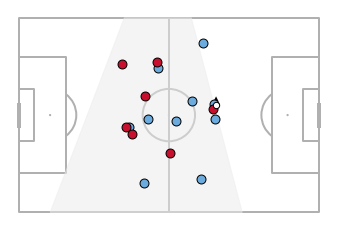

In [66]:
# Show the selected example
ex_action = test_db.actions(game_id=SAMPLE[0]).loc[SAMPLE]
display(ex_action.to_frame().T)

fig, ax = plt.subplots(figsize=(6,4))
ax = plot_action(ex_action, ax=ax)
plt.show()

In [15]:
features.simulate_features(test_db,3788743,xfns=features.all_features,actionfilter=None,
                           nb_prev_actions=3,xy=xy,
                           x_bins=104,y_bins=68,result='success')

AttributeError: 'dict' object has no attribute 'index'

Note that this is probably not a creative pass. It looks like a typical pass and it is not very useful.

## Load models

### Pass selection

In [ ]:
# model_pass_selection = pass_selection.SoccerMapComponent(
#     pass_selection.PytorchSoccerMapModel() )

In [ ]:
# model_pass_selection.train(dataset_train)

In [ ]:
# surface_pass_selection = model_pass_selection.predict_surface(dataset_test)

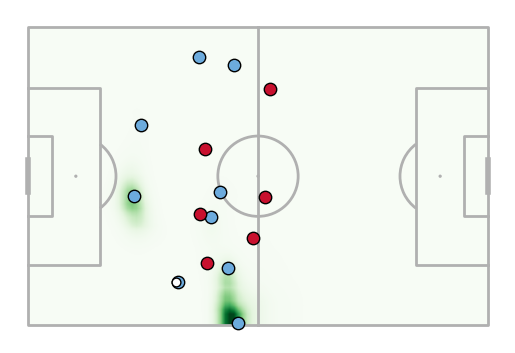

In [ ]:
# fig, ax = plt.subplots()
# ax = plot_action(
#     ex_action, surface=surface_pass_selection[SAMPLE[0]][SAMPLE[1]], 
#     show_visible_area=False, show_action=False,
#     ax=ax, surface_kwargs={**plt_settings, "vmin": None, "vmax": None, "cmap": "Greens"}
# )
# plt.show()

### Pass success

In [67]:
model_pass_success = pass_success.SoccerMapComponent(
    pass_success.PytorchSoccerMapModel()) 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [68]:
model_pass_success.train(dataset_train)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name      | Type      | Params
----------------------------------------
0 | model     | SoccerMap | 269 K 
1 | sigmoid   | Sigmoid   | 0     
2 | criterion | BCELoss   | 0     
----------------------------------------
269 K     Trainable params
0         Non-trainable params
269 K     Total params
1.078     Total estimated model params size (MB)


subset sampler value counts : train:[3055, 23130] & valid:[1018, 7711]


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


: 

### Pass value

In [ ]:
# model_pass_value = pass_value.SoccerMapComponent(
#     pass_value.PytorchSoccerMapModel() )

## Value creativity

In [ ]:
# model_pass_value.train(dataset_train)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


[07/28/23 17:48:39] INFO     Loading dataset from ../stores/datasets/default/train                  ]8;id=708526;file:///home/toc3/anaconda3/lib/python3.7/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=75898;file:///home/toc3/anaconda3/lib/python3.7/site-packages/lightning_utilities/core/rank_zero.py#32\32]8;;\

[07/28/23 17:48:41] INFO     Fitting model on train set                                             ]8;id=652913;file:///home/toc3/anaconda3/lib/python3.7/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=908549;file:///home/toc3/anaconda3/lib/python3.7/site-packages/lightning_utilities/core/rank_zero.py#32\32]8;;\


  | Name      | Type      | Params
----------------------------------------
0 | model     | SoccerMap | 269 K 
1 | sigmoid   | Sigmoid   | 0     
2 | criterion | MSELoss   | 0     
----------------------------------------
269 K     Trainable params
0         Non-trainable params
269 K     Total params
1.078     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


[07/28/23 18:05:34] INFO     Best checkpoint path:                                                  ]8;id=935520;file:///home/toc3/anaconda3/lib/python3.7/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=481909;file:///home/toc3/anaconda3/lib/python3.7/site-packages/lightning_utilities/core/rank_zero.py#32\32]8;;\
                             /home/toc3/un-xPass/notebooks/lightning_logs/version_12/checkpoints/ep                
                             och=0-step=819.ckpt                                                                   

In [ ]:
model_pass_selection = torch.load("./Pretrained_pass_selection_model/SoccerMap")
model_pass_success = torch.load("./Pretrained_pass_success_model/SoccerMap")
model_pass_value = torch.load("./Pretrained_pass_value_model/SoccerMap")

In [ ]:
rater = CreativeDecisionRating(
    pass_selection_component=model_pass_selection,
    pass_success_component=model_pass_success,
    pass_value_component=model_pass_value
)

In [ ]:
df_ratings = rater.rate(test_db, dataset_test)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

Output()

Output()

Output()

AttributeError: 'SoccerMapComponent' object has no attribute 'offensive_model'

In [ ]:
df_ratings.loc[SAMPLE]